In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc

In [2]:
######################### PART 1 - FACE DETECTION #########################
# -----------------------------Question 2-----------------------------

def MakeGaussianPyramid(image, scale, minsize): 
  pyramid = []
  img = image.copy()

  # Get the dimensions of the image
  width, height = img.size
  # Add the original image to the pyramid
  pyramid.append(np.asarray(img))

  while not (min(width, height) < minsize):
    # Decide the shape of the filtered array (L or RGB will be different)
    filtered_arr = np.ndarray(np.asarray(img).shape)

    # Smoothen the image with Gaussian filter with sigma=1
    if(img.mode == 'L'):
      filtered_arr = ndimage.gaussian_filter(np.asarray(img), 1)
    else:
      for i in range(3):
        # Apply the filter for each color channel
        filtered_arr[:,:,i] = ndimage.gaussian_filter(np.asarray(img)[:,:,i], 1)
    
    # Get the filtered image from the array
    img = Image.fromarray(filtered_arr.astype('uint8'))

    # Scale the filtered image 
    img = img.resize((int(width*scale),int(height*scale)), Image.BICUBIC)

    # Assign the new width and height values
    width, height = img.size

    # Add the new image to the pyramid
    pyramid.append(np.asarray(img))

  return pyramid

In [3]:
# -----------------------------Question 3-----------------------------

def ShowGaussianPyramid(pyramid):
  # Calculate the width of whole images by adding them
  width = 0
  for imgs in pyramid:
    width += imgs.shape[1]
  # Height can be equal to the height of the original image, it's the largest one
  height = pyramid[0].shape[0]

  # Initially, offsets are zero
  offset_x = 0
  offset_y = 0

  # Create a blank image, we will merge images into this
  merged = Image.new("RGB", (width, height), color='white')

  # Go through every image array in the pyramid, convert them into images
  # and paste them into the merging area.
  for imgs in pyramid:
    img = Image.fromarray(imgs.astype('uint8'))
    merged.paste(img,(offset_x,offset_y))
    offset_x += img.size[0]

  merged.save('p1q3.png','png')
  display(Image.open('p1q3.png'))

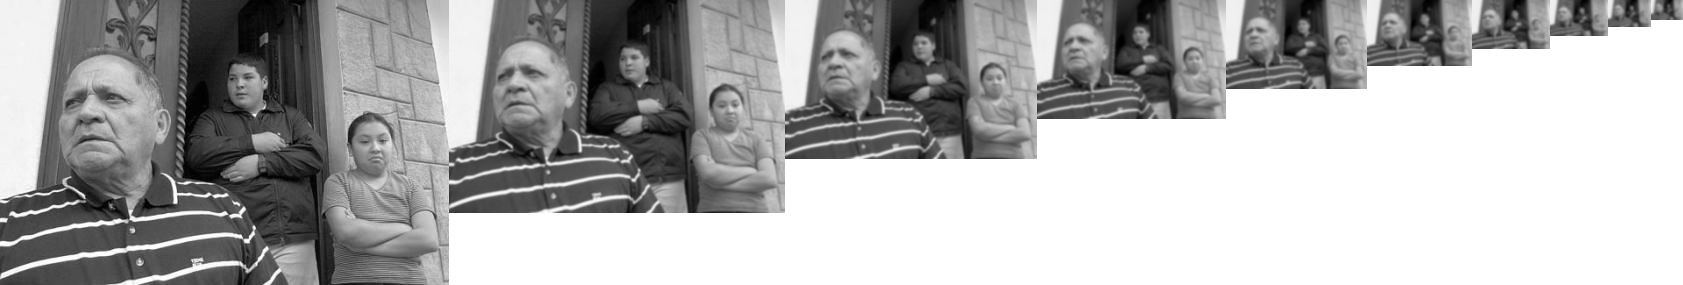

In [4]:
img = Image.open('hw2part1/faces/family.jpg')
pyramid = MakeGaussianPyramid(img, 0.75, 25)
ShowGaussianPyramid(pyramid)

In [5]:
# -----------------------------Question 4-----------------------------

def FindTemplate(pyramid, template, threshold):
  # Reduce the size of the template, make width 15 pixels
  temp = Image.fromarray(template.astype('uint8'))
  scale = 15/temp.size[0]
  template_scaled = temp.resize((int(temp.size[0]*scale),int(temp.size[1]*scale)), Image.BICUBIC)

  # Original image is the first image of the pyramid
  img = Image.fromarray(pyramid[0].astype('uint8'))
  img_arr = np.asarray(img).copy()

  # This will be the resulting image, we will place the bounding boxes on it
  img_res = Image.fromarray(pyramid[0].astype('uint8')).convert('RGB')

  # We need to go over each image in the pyramid, 
  # and find the template matching parts.
  for imgs in pyramid:
    p_img = Image.fromarray(imgs.astype('uint8'))
    # Normalized cross-correlation between the images and one template
    ncc_res = ncc.normxcorr2D(p_img, template_scaled)
    # Form a binary array to define the locations that has the higher value than the threshold
    # Shape of ncc_res and ncc_threshold is (h,w) while size of image is (w,h)
    ncc_threshold = ncc_res > threshold
    
    draw = ImageDraw.Draw(img_res)

    # We need to apply a scale to the locations and to the rectangle sizes.
    # Because if we find a match in the smaller images, we still need to draw
    # bounding boxes at the correct locations according to the original image.
    loc_scale = pyramid[0].shape[0]/imgs.shape[0]
    # For each value in the resulting binary array, if it is higher than the 
    # threshold, then draw a rectanle around that location.
    for row in range(0, ncc_threshold.shape[0]):
      for col in range(0, ncc_threshold.shape[1]):
        if ncc_threshold[row, col]:
          # Scaling the location for the original image
          y = int(loc_scale * row)
          x = int(loc_scale * col)

          c0 = [0, 0] # Top-left corner
          c1 = [0, 0] # Bottom-left corner
          c2 = [0, 0] # Top-right corner
          c3 = [0, 0] # Bottom-right corner

          # We find the corner locations to draw the ractangles
          # We also need to scale the rectangle sizes
          c0[0] = x - int(template_scaled.size[0]*loc_scale/2)
          c1[0] = x - int(template_scaled.size[0]*loc_scale/2)
          c2[0] = x + int(template_scaled.size[0]*loc_scale/2)
          c3[0] = x + int(template_scaled.size[0]*loc_scale/2)

          c0[1] = y - int(template_scaled.size[1]*loc_scale/2)
          c1[1] = y + int(template_scaled.size[1]*loc_scale/2)
          c2[1] = y - int(template_scaled.size[1]*loc_scale/2)
          c3[1] = y + int(template_scaled.size[1]*loc_scale/2)

          draw.line((c0[0],c0[1],c1[0],c1[1]),fill="red",width=2)
          draw.line((c1[0],c1[1],c3[0],c3[1]),fill="red",width=2)
          draw.line((c2[0],c2[1],c3[0],c3[1]),fill="red",width=2)
          draw.line((c2[0],c2[1],c0[0],c0[1]),fill="red",width=2)
    del draw
            
  return np.asarray(img_res)

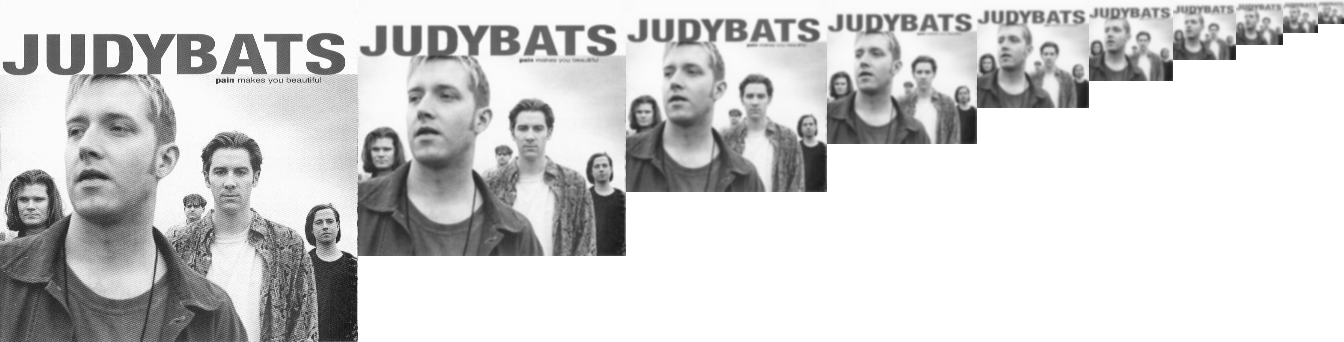

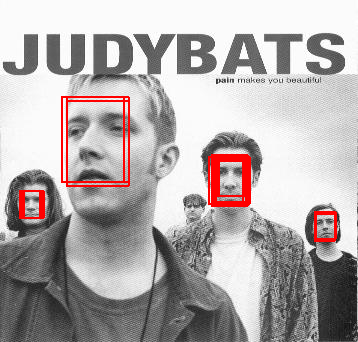

In [6]:
# Show the Gaussian pyramid
img_judybats = Image.open('hw2part1/faces/judybats.jpg')
pyr_judybats = MakeGaussianPyramid(img_judybats, 0.75, 25)
ShowGaussianPyramid(pyr_judybats)

# Upload the template image
template = Image.open('face_detection_template.jpeg')
template_arr = np.asarray(template)

# Return the image with detected faces and display
threshold = 0.66
judybats_match_arr = FindTemplate(pyr_judybats, template_arr, threshold)
judybats_match_img = Image.fromarray(judybats_match_arr.astype('uint8'))
judybats_match_img.save('p1q4.png', 'png')
display(Image.open('p1q4.png'))

In [7]:
# -----------------------------Question 5-----------------------------

def TestFaceDetection(image_name, temp_arr, threshold):
  # Upload the image
  img_q5 = Image.open('hw2part1/faces/'+image_name+'.jpg')
  # Generate the Gaussian pyramid for that image
  pyr_q5 = MakeGaussianPyramid(img_q5, 0.75, 75)
  # Find the matching parts with the template
  matched_arr = FindTemplate(pyr_q5, temp_arr, threshold)
  matched_img = Image.fromarray(matched_arr.astype('uint8'))
  matched_img.save('p1q5_'+image_name+'.png', 'png')
  display(Image.open('p1q5_'+image_name+'.png'))

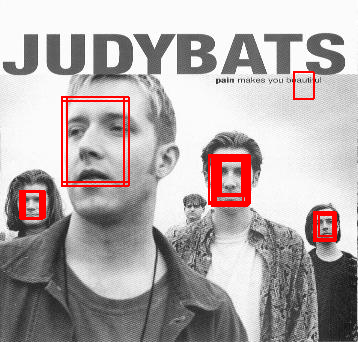

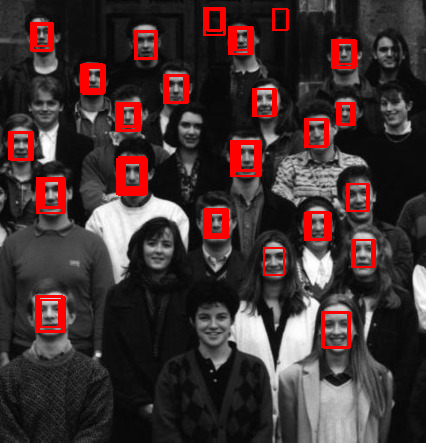

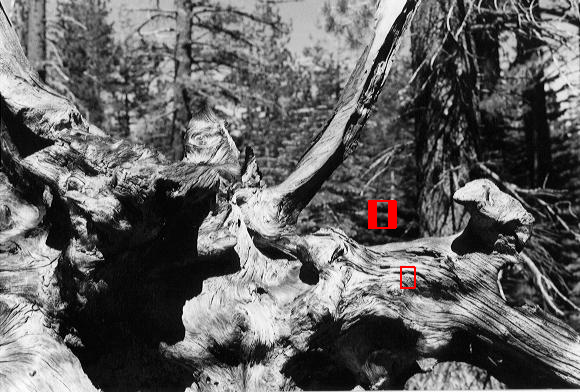

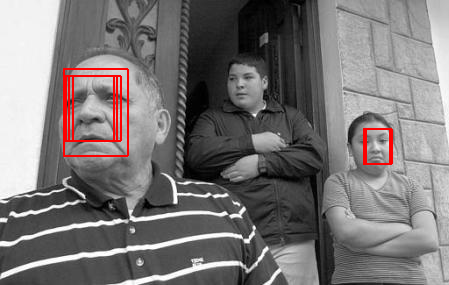

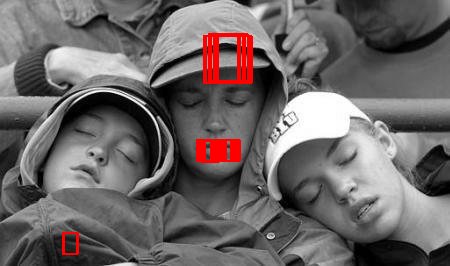

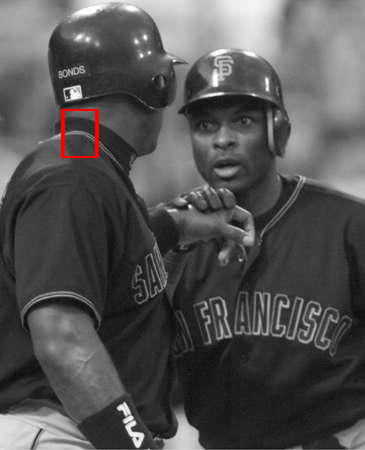

In [8]:
# Images that we will test
image_names = ['judybats', 'students', 'tree', 'family', 'fans', 'sports']

# Threshold value
threshold_q5 = 0.60

# For every image in the image array, call TestFaceDetection method
for image_name in image_names:
  TestFaceDetection(image_name, template_arr, threshold_q5)

Number of False Positives - False Negatives for Threshold = 0.6:

*   Judybats : 1-1
*   Students : 2-6
*   Tree : 2-0
*   Family : 0-1
*   Fans : 4-3
*   Sports : 1-1

Total : 10 False Positives - 12 False Negatives


In [9]:
# -----------------------------Question 6-----------------------------

# Recall = TruePositive/(TruePositive+FalseNegative)
def recall(tp,fn):
  if(tp+fn) == 0:
    # If the denominator is 0, return -1 means undefined
    return -1
  else:
    return tp/(tp+fn)

for img in image_names:
  if(img == 'judybats'):
    print('Recall for', img, ':', recall(4,1))
  elif(img == 'students'):
    print('Recall for', img, ':', recall(21,6))
  elif(img == 'tree'):
    print('Recall for', img, ':', recall(0,0))
  elif(img == 'family'):
    print('Recall for', img, ':', recall(2,1))
  elif(img == 'fans'):
    print('Recall for', img, ':', recall(0,3))
  elif(img == 'sports'):
    print('Recall for', img, ':', recall(0,1))

Recall for judybats : 0.8
Recall for students : 0.7777777777777778
Recall for tree : -1
Recall for family : 0.6666666666666666
Recall for fans : 0.0
Recall for sports : 0.0


NCC has very low recall rate especially for fans and sports image. It is equal to zero because it couldn't catch any true positives. In fans image, there are 3 faces, but NCC couldn't include any of them. It only marked some locations around the lips and hat of the person in the middle. That's why, number true positives is zero, and number of false negatives is 3. In sports image, there is 1 face, but NCC couldn't catch that face either. Therefore, number of true positives is 0. And this yields that the recall rate is 0.

NCC cannot decide whether there is a match or not when some objects cover a part of the shape (hairs falling on foreheads in the students image), or if the objects are rotated (two kids in the fans image), or it is too small to capture the details (the guy standing behind in the judybats image), or face is not towards the camera (the boy in the family image), or shadows prevents detection (the player in the sports image). If we can use an algorithm that can cover these situations, we would have a higher recall rate.

In [10]:
######################### PART 2 - IMAGE BLENDING #########################
# -----------------------------Question 2-----------------------------

def MakeLaplacianPyramid(image, scale, minsize):
  # Create a Gaussian pyramid
  gaussian_pyr = MakeGaussianPyramid(image, scale, minsize)

  # Number of images in the Gaussian pyramis
  gaussian_len = len(gaussian_pyr)

  # Define the Laplacian pyramid
  laplacian_pyr = []

  # Take the difference between one Gaussian pyramid level and the next
  if(gaussian_len >= 2):
    for image in range(gaussian_len-1):
      # Get the image
      orig_img_arr = gaussian_pyr[image]
      # Define the shape of the blurred image with the same shape of original
      blur_img_arr = np.ndarray(orig_img_arr.shape)

      # Calculate the blurred version of that image for each color channel
      for i in range(3):
        blur_img_arr[:,:,i] = ndimage.gaussian_filter(orig_img_arr[:,:,i], 1)

      # To calculate the residual:
      # Take the difference between one Gaussian pyramid level and the next
      residual_img_arr = orig_img_arr - blur_img_arr

      laplacian_pyr.append(residual_img_arr)

    # The highest level of both Gaussian and Laplacian pyramid is the same
    laplacian_pyr.append(gaussian_pyr[gaussian_len-1])

  return laplacian_pyr

In [11]:
# -----------------------------Question 3-----------------------------

def ShowLaplacianPyramid(pyramid):
  # Calculate the width of whole images by adding them
  width = 0
  for imgs in pyramid:
    width += imgs.shape[1]
  # Height can be equal to the height of the original image, it's the largest one
  height = pyramid[0].shape[0]

  # Initially, offsets are zero
  offset_x = 0
  offset_y = 0

  # Create a blank image, we will merge images into this
  merged = Image.new("RGB", (width, height), color='white')

  # Go through every image array in the pyramid, 
  for imgs in pyramid[:-1]:
    # Add this value to appropriate viewing
    img_pyr_128 = imgs + 128
    # Clip the pixel values between 0-255
    img_pyr_clip = np.clip(img_pyr_128, 0, 255)
    img = Image.fromarray(img_pyr_clip.astype('uint8'))
    merged.paste(img,(offset_x,offset_y))
    offset_x += img.size[0]

  merged.paste(Image.fromarray(pyramid[-1].astype('uint8')), (offset_x,offset_y))

  merged.save('p2q3.png','png')
  display(Image.open('p2q3.png'))

Laplacian pyramid for Orchid


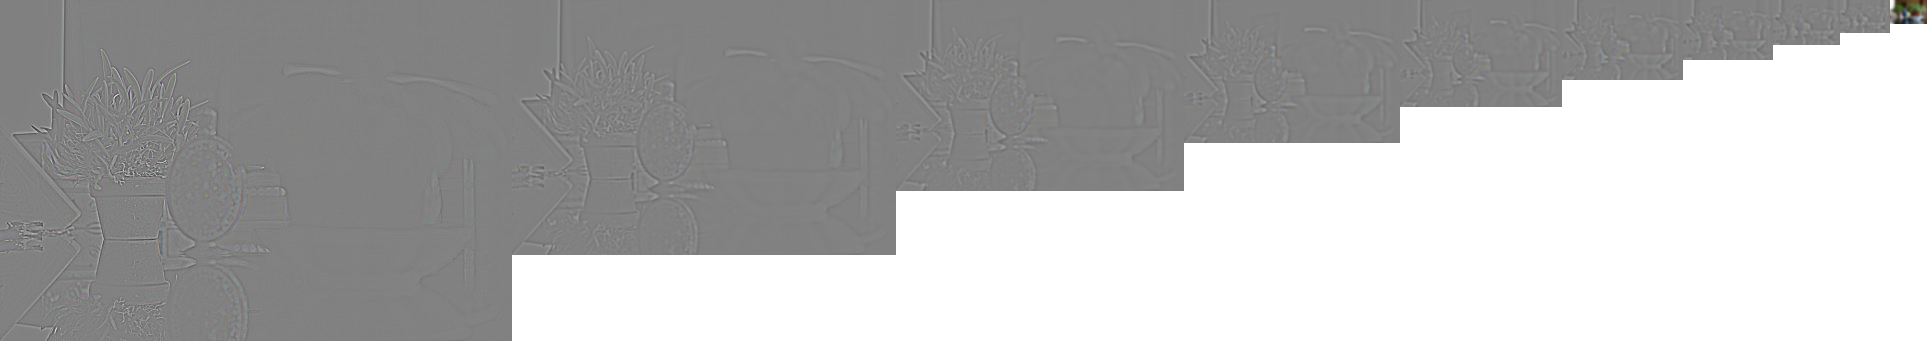

Laplacian pyramid for Violet


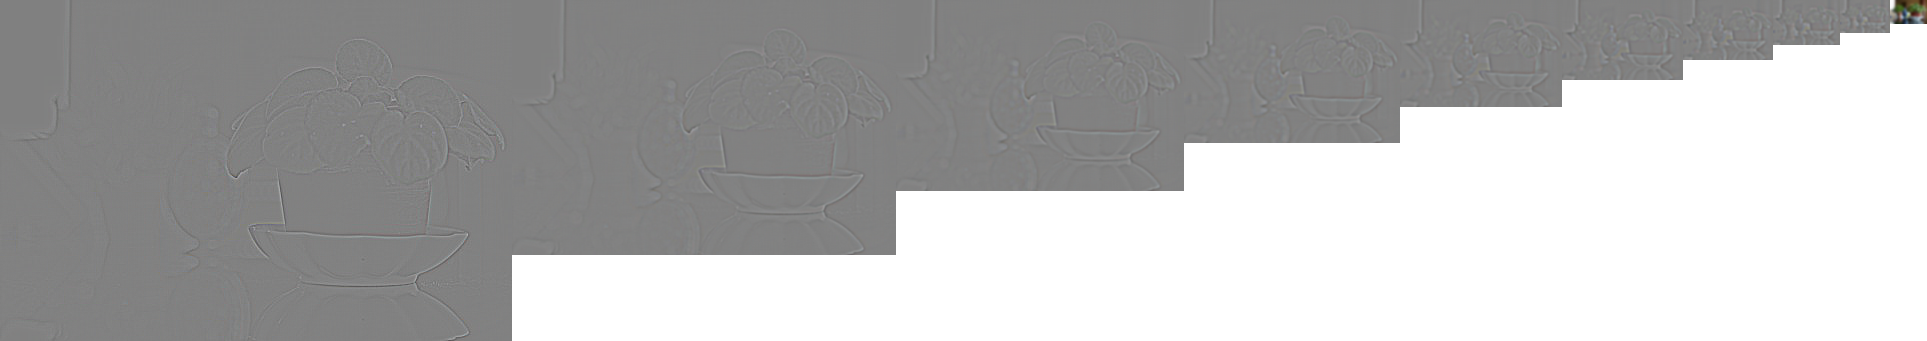

In [12]:
# Create and show Laplacian pyramid for orchid
img_orchid = Image.open('hw2part2/orchid.jpg')
laplacian_pyr_orchid = MakeLaplacianPyramid(img_orchid, 0.75, 25)
print('Laplacian pyramid for Orchid')
ShowLaplacianPyramid(laplacian_pyr_orchid)

# Create and show Laplacian pyramid for violet
img_violet = Image.open('hw2part2/violet.jpg')
laplacian_pyr_violet = MakeLaplacianPyramid(img_violet, 0.75, 25)
print('Laplacian pyramid for Violet')
ShowLaplacianPyramid(laplacian_pyr_violet)

In [13]:
# -----------------------------Question 4-----------------------------

def ReconstructGaussianFromLaplacianPyramid(lPyramid):
  # This will be the reconstructed Gaussian pyramid
  reconstructed = []
  # Append the last image to the Gaussian pyramid directly
  reconstructed.append(lPyramid[len(lPyramid)-1])

  # Traverse over the lPyramid from end to the beginning 
  for i in reversed(range(len(lPyramid)-1)):
    # Take the first Gaussian image
    img_to_upsample = Image.fromarray(reconstructed[0].astype('uint8'))
    # Upsample it
    img_upsampled = img_to_upsample.resize((lPyramid[i].shape[1], lPyramid[i].shape[0]), Image.BICUBIC)
    
    # This will be the blurred image array
    img_up_blurred = np.ndarray(np.asarray(img_upsampled).shape)

    # Apply Gaussian blurring filter for each color channel
    for j in range(3):
      img_up_blurred[:,:,j] = ndimage.gaussian_filter(np.asarray(img_upsampled)[:,:,j], 1)

    # Summation of blurred image and residual
    result_arr = img_up_blurred + lPyramid[i]

    reconstructed.insert(0, result_arr)

  return reconstructed

Reconstructed Gaussian pyramid for Orchid


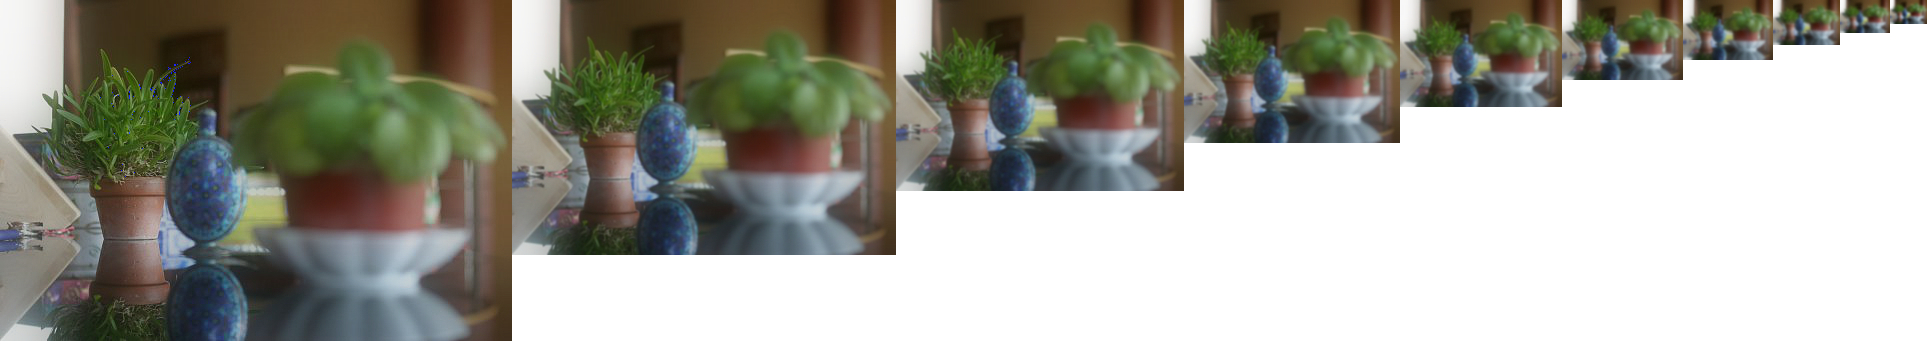

Reconstructed Gaussian pyramid for Violet


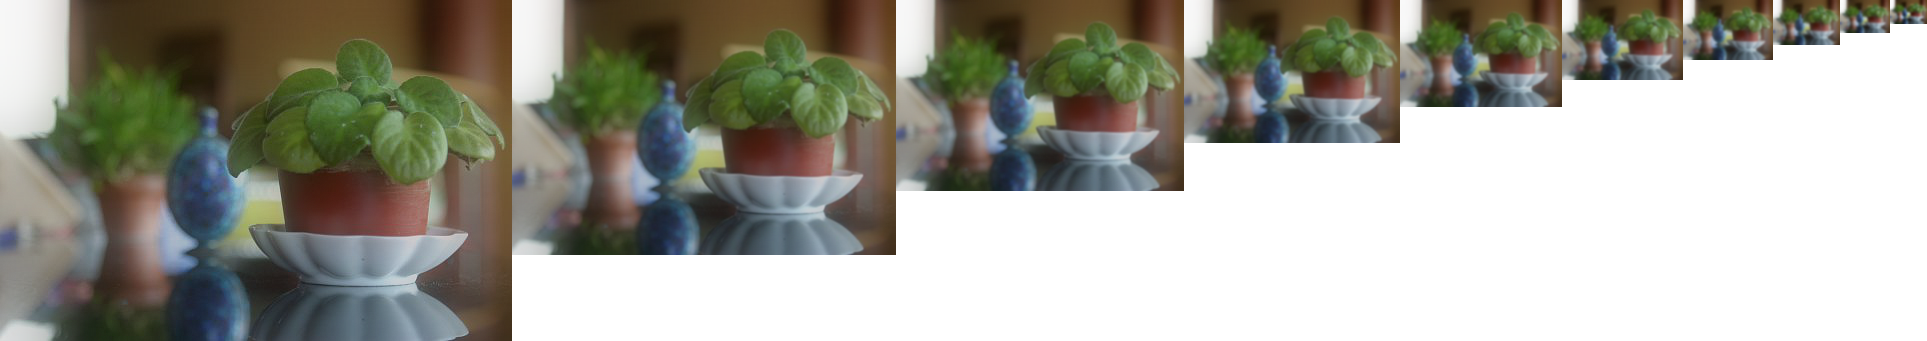

In [14]:
# Show the reconstructed Gaussian pyramid result for Orchid
reconstruct_orchid = ReconstructGaussianFromLaplacianPyramid(laplacian_pyr_orchid)
print('Reconstructed Gaussian pyramid for Orchid')
ShowGaussianPyramid(reconstruct_orchid)

# Show the reconstructed Gaussian pyramid result for Violet
reconstruct_violet = ReconstructGaussianFromLaplacianPyramid(laplacian_pyr_violet)
print('Reconstructed Gaussian pyramid for Violet')
ShowGaussianPyramid(reconstruct_violet)

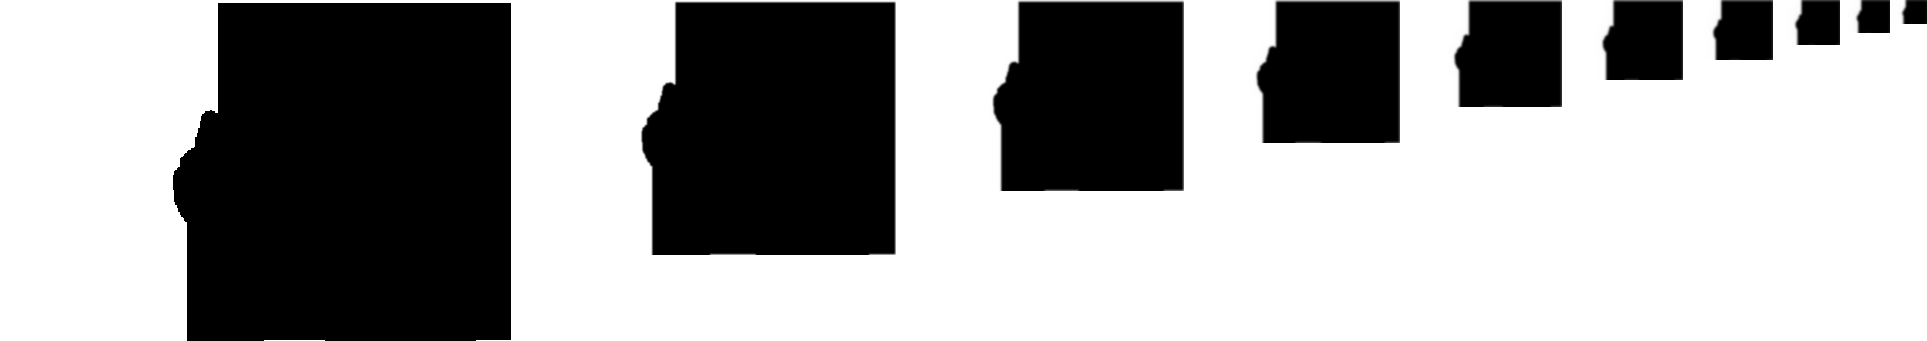

In [15]:
# -----------------------------Question 5-----------------------------

# Upload the image
img_orchid_mask = Image.open('hw2part2/orchid_mask.bmp')
# Generate and show the Gaussian pyramid
orchid_mask_gPyr = MakeGaussianPyramid(img_orchid_mask, 0.75, 25)
ShowGaussianPyramid(orchid_mask_gPyr)

In [16]:
# -----------------------------Question 6-----------------------------

def ComposeTwoLaplacian(img_A, img_B, img_M, scale, minsize):
  # Upload the images(.jpg) and mask(.bmp)
  imgA = Image.open('hw2part2/'+img_A+'.jpg')
  imgB = Image.open('hw2part2/'+img_B+'.jpg')
  imgM = Image.open('hw2part2/'+img_M+'.bmp').convert('RGB')
  
  # Create Laplacian pyramids for images, and Gaussian pyramid for mask
  lapA = MakeLaplacianPyramid(imgA, scale, minsize)
  lapB = MakeLaplacianPyramid(imgB, scale, minsize)
  gaussianM = MakeGaussianPyramid(imgM, scale, minsize)

  # Array of composed two Laplacians
  compLaplacian = []
  for ind in range(len(lapA)-1):
    compLaplacian.append(lapA[ind] * gaussianM[ind]/255 +  lapB[ind] * (1 - gaussianM[ind]/255))
  
  # Last element of the Composed Laplacian is the same with the last element
  # of the other Laplacian pyramids
  compLaplacian.append(lapA[-1])

  # Resulting image
  result = None

  # Separate calculation for the last element of the Laplacian pyramid
  last_img = Image.fromarray(compLaplacian[-1].astype('uint8'))
  last_img_up = last_img.resize((compLaplacian[-2].shape[1], compLaplacian[-2].shape[0]), Image.BICUBIC)

  img_up_blurred = np.ndarray(np.asarray(last_img_up).shape)
  for k in range(3):
    img_up_blurred[:,:,k] = ndimage.gaussian_filter(np.asarray(last_img_up)[:,:,k], 0.1)

  result = img_up_blurred + compLaplacian[-2]

  # For the remaining elements in the Composed Laplacian pyramid
  # Upsample, blurr the photo, then add this one to the next level's photo
  for i in reversed(range(1,len(compLaplacian)-2)):
    comp_lap_img = Image.fromarray(result.astype('uint8'))
    comp_lap_img_up = comp_lap_img.resize((compLaplacian[i-1].shape[1], compLaplacian[i-1].shape[0]), Image.BICUBIC)
    
    img_up_blurred = np.ndarray(np.asarray(comp_lap_img_up).shape)
    for k in range(3):
      img_up_blurred[:,:,k] = ndimage.gaussian_filter(np.asarray(comp_lap_img_up)[:,:,k], 0.1)

    result = img_up_blurred + compLaplacian[i-1]

  # Clip the resulting image to reduce the artifacts
  img_result = Image.fromarray(np.clip(result, 0.0, 255.0).astype('uint8'))
  return img_result


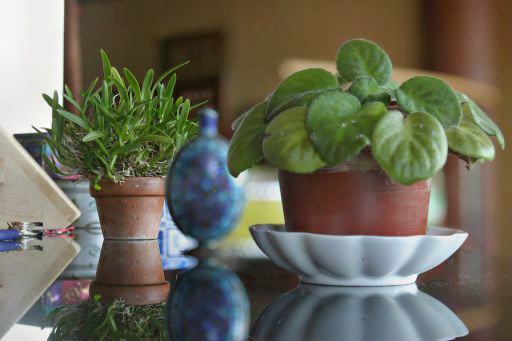

In [17]:
img_orc_vio = ComposeTwoLaplacian('orchid','violet','orchid_mask',0.75,10)
img_orc_vio.save('p2q6.png', 'png')
display(Image.open('p2q6.png'))

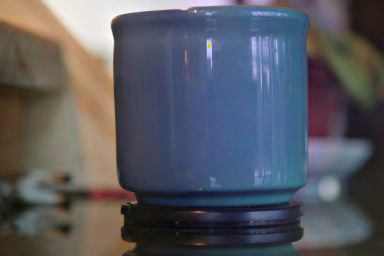

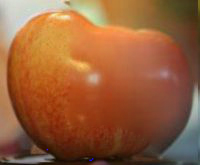

In [18]:
# -----------------------------Question 6-----------------------------
img_blue_green = ComposeTwoLaplacian('blue_cup','green_cup','cup_mask',0.75,10)
img_blue_green.save('p2q7_1.png', 'png')
display(Image.open('p2q7_1.png'))

img_app_tom = ComposeTwoLaplacian('apple','tomato','tomato_mask',0.75,10)
img_app_tom.save('p2q7_2.png', 'png')
display(Image.open('p2q7_2.png'))

From the shapes of the cup and the apple, you can see that the images are blended. Their colors are also matched. That's why we can't see the green cup very expilicitly. But you can verify the blending by looking at the shape.